# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (ie 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - 
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1]:
import pandas as pd
import numpy as np
import math
import json
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
from sklearn import svm
from time import time
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier

#from xgboost import XGBClassifier
%matplotlib inline

# read in the json files
portfolio = pd.read_json('portfolio.json', orient='records', lines=True)
profile = pd.read_json('profile.json', orient='records', lines=True)
# transcript = pd.read_json('transcript.json', orient='records', lines=True)
transcript=pd.read_csv('transcript_expanded.csv')

Data Exploration

In [2]:
portfolio['offer_type'].unique()

array(['bogo', 'informational', 'discount'], dtype=object)

In [3]:
portfolio.head()

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [4]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [5]:
portfolio.rename(columns={'id':'offer_id'},inplace=True)

In [6]:
profile.rename(columns={'id':'person'},inplace=True)

Data Cleaning
1. extract different values from transcript into different columns.
2. offer_id into offer id

In [7]:
transcript['person'].nunique()

17000

In [8]:
transcript['offer_id'].nunique()

8

In [9]:
portfolio['offer_id'].nunique()

10

In [10]:
#expand value column in transcript
# transcript=pd.concat([transcript, transcript['value'].apply(pd.Series)], axis=1)
# transcript.to_csv('transcript_expanded.csv',index=False)

transcript=pd.read_csv('transcript_expanded.csv')

In [11]:
#create new column to ensure only one offer_id column
transcript['offer_id_new']=np.where(transcript['offer id'].isnull() & transcript['offer_id'].notnull(),transcript['offer_id'],transcript['offer id'])

#drop unnecessary offer_id columns
transcript.drop(['offer id','offer_id'],axis=1,inplace=True)

#rename offer_id column
transcript.rename(columns={'offer_id_new':'offer_id'},inplace=True)

In [12]:
portfolio.rename(columns={'id':'offer_id'},inplace=True)

In [13]:
transcript=transcript.merge(portfolio,how='left',on='offer_id')

In [14]:
transcript['day_offer']=transcript['time']/24

In [15]:
transcript=transcript.sort_values(['person','day_offer'])

In [16]:
def drop_cols(drop_cols,df,inplace=False):
    df=df.drop(columns=drop_cols,axis=1,inplace=inplace)
    return df

In [17]:
drop_cols(['value','time','reward_y'],transcript,inplace=True);

In [18]:
offers_view_transacted2=transcript[['day_offer','offer_id','person','event']][(transcript['event']=='transaction') | (transcript['event']=='offer viewed')].ffill()

In [19]:
transactions_clean=transcript.merge(offers_view_transacted2,how='left',on=['person','day_offer','event'])

In [20]:
transactions_clean['offer_id']=np.where(transactions_clean['offer_id_x'].isnull(),transactions_clean['offer_id_y'],transactions_clean['offer_id_x'])

drop_cols(['offer_id_x','offer_id_y'],transactions_clean,inplace=True);

In [21]:
transactions_clean=transactions_clean.merge(portfolio,how='left',on='offer_id')

In [22]:
transactions_clean.columns

Index(['event', 'person', 'amount', 'reward_x', 'channels_x', 'difficulty_x',
       'duration_x', 'offer_type_x', 'day_offer', 'offer_id', 'channels_y',
       'difficulty_y', 'duration_y', 'offer_type_y', 'reward'],
      dtype='object')

In [23]:
transactions_clean['duration']=np.where(transactions_clean['duration_x'].isnull(),transactions_clean['duration_y'],transactions_clean['duration_x'])

In [24]:
drop_cols(['duration_x','offer_type_x','difficulty_x','channels_x','duration_y'],transactions_clean,inplace=True);

In [25]:
transactions_clean.rename(columns={'channels_y':'channels','reward_x':'reward','difficulty_y':'difficulty','offer_type_y':'offer_type'},inplace=True)

In [26]:
offers_viewed_transactions_completed=transactions_clean[(transactions_clean['event']=='offer viewed') | (transactions_clean['event']=='transaction') | (transactions_clean['event']=='offer completed')].copy()

In [27]:
offers_received=transactions_clean[transactions_clean['event']=='offer received'].copy()

In [28]:
offers_viewed_transactions_completed['offer_id_previous'] = offers_viewed_transactions_completed.groupby(['person','offer_id'])['offer_id'].shift()

In [29]:
offers_viewed_transactions_completed['valid_completed']=np.where(offers_viewed_transactions_completed['offer_id_previous']==offers_viewed_transactions_completed['offer_id'],1,0)

In [30]:
offers_viewed_transactions_completed.columns

Index(['event', 'person', 'amount', 'reward', 'day_offer', 'offer_id',
       'channels', 'difficulty', 'offer_type', 'reward', 'duration',
       'offer_id_previous', 'valid_completed'],
      dtype='object')

In [31]:
offers_received.columns

Index(['event', 'person', 'amount', 'reward', 'day_offer', 'offer_id',
       'channels', 'difficulty', 'offer_type', 'reward', 'duration'],
      dtype='object')

In [32]:
offers_received['offer_id_previous']=np.nan
offers_received['valid_completed']=np.nan

In [33]:
transactions_clean2=offers_received.append(offers_viewed_transactions_completed)

In [34]:
transactions_clean2=transactions_clean2.sort_values(['person','day_offer','event','offer_id'])

In [35]:
transactions_clean2['diff_info']=transactions_clean2[(transactions_clean2['offer_type']=='informational') & ((transactions_clean2['event']=='offer received') | (transactions_clean2['event']=='transaction'))].groupby(['person','offer_id'])['day_offer'].diff()

In [36]:
transactions_clean2['diff_bogo']=transactions_clean2[(transactions_clean2['offer_type']=='bogo') & ((transactions_clean2['event']=='offer received') | (transactions_clean2['event']=='offer completed'))].groupby(['person','offer_id'])['day_offer'].diff()

In [37]:
transactions_clean2['diff_discount']=transactions_clean2[(transactions_clean2['offer_type']=='discount') & ((transactions_clean2['event']=='offer received') | (transactions_clean2['event']=='offer completed'))].groupby(['person','offer_id'])['day_offer'].diff()

In [38]:
transactions_clean2['valid_completed_duration']=np.nan

In [39]:
transactions_clean2.loc[transactions_clean2['diff_info']<=transactions_clean2['duration'],'valid_completed_duration']=1
transactions_clean2.loc[transactions_clean2['diff_discount']<=transactions_clean2['duration'],'valid_completed_duration']=1
transactions_clean2.loc[transactions_clean2['diff_bogo']<=transactions_clean2['duration'],'valid_completed_duration']=1

In [40]:
transactions_clean2['valid_completed_duration']=transactions_clean2['valid_completed_duration'].fillna(value=0)

In [41]:
df_offer_received_cnt=transactions_clean2[transactions_clean2['event']=='offer received'].groupby(['person','offer_id']).count()['event'].reset_index()

In [42]:
df_offer_received_cnt.rename(columns={'event':'offer_received_cnt'},inplace=True)

In [43]:
df_transactions_invalid=transactions_clean2[(transactions_clean2['event']=='transaction') & (transactions_clean2['valid_completed']==0)].groupby(['person','offer_id'])['amount'].sum().reset_index()
df_transactions_invalid.rename(columns={'amount':'amount_invalid'},inplace=True)

In [92]:
transactions_clean2['time_elapsed_offers']=transactions_clean2[transactions_clean2['event']=='offer received'].groupby(['person','offer_id'])['day_offer'].diff()

In [99]:
transactions_clean2['time_elapsed_offers']=transactions_clean2['time_elapsed_offers'].fillna(value=0)

In [103]:
df_time_elapsed=transactions_clean2.groupby(['person','offer_id'])['time_elapsed_offers'].sum().reset_index()

Effective offers: (get group of people & IDs who have valid_completed & valid_completed_duration for "offer completed" & "transaction" - unique by person, offerID and offer type)
- Bogo/discount: Received -> viewed -> transaction -> offer completed
- Info: Received -> viewed -> transaction

Ineffective offers: (get group of unique people & offer IDs who have any of the below but not valid_completed or valid_completed duration (unique))
- Bogo/discount: Received -> transaction -> offer completed -> viewed
- Bogo/discount: Received -> transaction -> offer completed 
- Bogo/discount: Received -> viewed
- Info: Received -> viewed

In [104]:
def offers_prep(df,offer_type):
    #split df by offer type
    temp=df[df['offer_type']==offer_type].copy()
    #tag effective offers, split and recombine table
    temp['effective_offers']=np.where((temp['valid_completed']==1) & (temp['valid_completed_duration']==1),1,0)
    ineffective_offers=temp[temp['effective_offers']==0].groupby(['person','offer_id']).sum().reset_index()[['person','offer_id']]
    effective_offers=temp[temp['effective_offers']==1].groupby(['person','offer_id']).sum().reset_index()[['person','offer_id']]
    #re-create new column flag
    ineffective_offers['effective_offer']=0
    effective_offers['effective_offer']=1
    final_df=effective_offers.append(ineffective_offers)
    return final_df

In [105]:
offers_bogo=offers_prep(transactions_clean2,'bogo');
offers_info=offers_prep(transactions_clean2,'informational');
offers_discount=offers_prep(transactions_clean2,'discount');

In [106]:
#get unique people who received offers
received_offers=pd.Series(transactions_clean2[transactions_clean2['event']=='offer received']['person'].unique())
#get people who purchased but did not receive any offers
no_received_offers=pd.Series(transactions_clean2[np.logical_not(transactions_clean2['person'].isin(received_offers))]['person'].unique())

In [109]:
def prep_offers_df(df):
    #define rename function
    def rename(col_name,df):
        df[col_name]=np.where(df[col_name]==col_name,1,0)
        return df
    #merge to get user profile, offers received count and offer characteristics 
    df=df.merge(df_time_elapsed[['person','offer_id','time_elapsed_offers']],how='left',on=['person','offer_id'])
    df=df.merge(df_offer_received_cnt[['person','offer_id','offer_received_cnt']],how='left',on=['person','offer_id'])
    df=df.merge(df_transactions_invalid[['person','offer_id','amount_invalid']],how='left',on=['person','offer_id'])
    df=df.merge(portfolio,how='left',on='offer_id')
    #convert channels into categorical variables
    channels = df['channels'].apply(pd.Series)
    channels = channels.rename(columns={0:'web',1:'email',2:'mobile',3:'social'})
    df=pd.concat([df[:], channels[:]], axis=1)
    rename('web',df)
    rename('email',df)
    rename('mobile',df)
    rename('social',df)
    df=drop_cols('channels',df)
    return df

In [110]:
offers_bogo=prep_offers_df(offers_bogo)

In [111]:
offers_discount=prep_offers_df(offers_discount)

In [112]:
offers_bogo.isnull().sum().sort_values(ascending=False)

amount_invalid            33945
income                     3743
gender                     3743
offer_received_cnt         1745
membership_tenure_days        0
duration                      0
offer_id                      0
effective_offer               0
time_elapsed_offers           0
difficulty                    0
offer_type                    0
social                        0
reward                        0
age                           0
web                           0
email                         0
mobile                        0
person                        0
dtype: int64

In [113]:
offers_discount.isnull().sum().sort_values(ascending=False).head()

amount_invalid            35361
income                     3964
gender                     3964
offer_received_cnt         1458
membership_tenure_days        0
dtype: int64

Missing values treatment

In [114]:
#check for missing values
print(offers_bogo['gender'].isnull().sum()/len(offers_bogo))
print(offers_bogo['income'].isnull().sum()/len(offers_bogo))

0.10088676855071292
0.10088676855071292


In [115]:
offers_bogo['age'].unique()

array([ 40,  59,  24,  55,  54,  28,  62,  88,  50,  94,  44,  52,  58,
        47,  22,  71,  45,  57,  19, 118,  86,  67,  61,  70,  56,  68,
        20,  75,  74,  87,  53,  60,  63,  64,  39,  83,  46,  81,  84,
        26,  32,  37,  51,  21,  66,  41,  77,  35,  36,  69,  80,  49,
        65,  42,  29,  73,  72,  93,  78,  85,  48,  31,  30,  90,  33,
        79,  18,  27,  43,  34,  25,  76,  38,  92,  96, 101,  23,  89,
        91,  82,  95, 100,  99,  97,  98], dtype=int64)

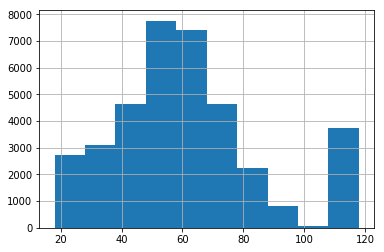

In [116]:
offers_bogo['age'].hist()

In [117]:
offers_bogo[['age','gender','income']][offers_bogo['income'].isnull()].head()
#we can see that the age is not useful in the cases where gender and income are null. Hence, can drop these values

,age,gender,income
30,118,None,NaN
64,118,None,NaN
83,118,None,NaN
190,118,None,NaN
203,118,None,NaN


In [118]:
offers_bogo.dropna(subset=['age','gender','income'],axis=0,inplace=True)

In [119]:
offers_bogo.isnull().sum().sort_values(ascending=False)

amount_invalid            30519
offer_received_cnt         1557
membership_tenure_days        0
social                        0
offer_id                      0
effective_offer               0
time_elapsed_offers           0
difficulty                    0
duration                      0
offer_type                    0
reward                        0
age                           0
gender                        0
income                        0
web                           0
email                         0
mobile                        0
person                        0
dtype: int64

In [120]:
#fill missing values
offers_bogo['amount_invalid'].fillna(value=0,inplace=True)
offers_bogo['offer_received_cnt'].fillna(value=0,inplace=True)

In [121]:
#do the same for other datasets
def missing_val(df):
    df.dropna(subset=['age','gender','income'],axis=0,inplace=True)
    df['amount_invalid'].fillna(value=0,inplace=True)
    df['offer_received_cnt'].fillna(value=0,inplace=True)
    return df

In [122]:
offers_discount=missing_val(offers_discount)

In [123]:
#get dummy variables for gender column for both
def gender(df):
    df=pd.concat([df[:],pd.get_dummies(df['gender'],prefix='gender')],axis=1)
    df=drop_cols('gender',df) 
    return df

In [124]:
offers_discount=gender(offers_discount)
offers_bogo=gender(offers_bogo)

Special treatment for offers_info 

In [125]:
def prep_offers_info(df):    
    #convert became_member_on into member tenure
    df['year']=pd.Series([int(str(x)[:4]) for x in df['became_member_on']])
    df['month']=pd.Series([int(str(x)[-3]) for x in df['became_member_on']])
    df['day']=pd.Series([int(str(x)[-2:]) for x in df['became_member_on']])
    df=drop_cols('became_member_on',df)
    df.loc[df['year'] == 2018, 'membership_tenure_days'] = (30*df['month'])+df['day']
    df.loc[df['year'] != 2018, 'membership_tenure_days'] = ((2018-df['year'])*365)+(30*df['month'])+df['day']
    df=drop_cols(['year','month','day'],df)
    return df

In [126]:
offers_info=offers_info.merge(df_time_elapsed[['person','offer_id','time_elapsed_offers']],how='left',on=['person','offer_id'])
offers_info=offers_info.merge(df_offer_received_cnt[['person','offer_id','offer_received_cnt']],how='left',on=['person','offer_id'])
offers_info=offers_info.merge(df_transactions_invalid[['person','offer_id','amount_invalid']],how='left',on=['person','offer_id'])
offers_info=offers_info.merge(portfolio,how='left',on='offer_id')
offers_info=offers_info.merge(profile,how='left',on='person')

In [127]:
def channel_col(name,df=offers_info):
    df[name]= np.nan
    df.loc[pd.Series([name in df['channels'][x] for x in range(len(df['channels']))]),name]=1
    df[name]=df[name].fillna(value=0)
    return df

In [128]:
channel_col('web')
channel_col('email')
channel_col('mobile')
channel_col('social');

In [129]:
drop_cols('channels',offers_info,inplace=True);

In [130]:
offers_info=prep_offers_info(offers_info)

In [131]:
#check missing values    
offers_info.isnull().sum().sort_values(ascending=False).head()

amount_invalid            17882
income                     2422
gender                     2422
offer_received_cnt          984
membership_tenure_days        0
dtype: int64

In [132]:
#missing values treatment
offers_info=missing_val(offers_info)

In [133]:
#get dummy variables for gender column
offers_info=gender(offers_info)    

In [134]:
def get_transactions(df,offer_type):
    temp=transactions_clean2[['person','amount','offer_id']][(transactions_clean2['event']=='transaction') & (transactions_clean2['offer_type']=='bogo')]
    temp=temp.groupby(['person','offer_id']).sum()['amount'].reset_index()
    df=df.merge(temp,how='left',on=['person','offer_id'])
    df['amount']=df['amount'].fillna(value=0)
    return df

In [135]:
offers_discount=get_transactions(offers_discount,'discount')
offers_bogo=get_transactions(offers_bogo,'bogo')
offers_info=get_transactions(offers_info,'informational')

4 individual models - identify features demographic types that would respond to each type of offer effectively. 3 types of offers, and one type which does not purchase any at all (only 20 records).

Predict how much someone would spend based on type of offer, channel, demographics, etc.

Overall multiclass model - only for effective offers.

All in all, 6 total models.

There may be people who viewed and completed offers (effective offers) but no transaction associated.

Model 1: Determine what are the drivers of effectiveness of bogo type offers

In [136]:
# #drop duplicates
# offers_bogo_tmp=offers_bogo.drop_duplicates(subset=['person','offer_id']).copy()
# offers_discount_tmp=offers_discount.drop_duplicates(subset=['person','offer_id']).copy()
# offers_info_tmp=offers_info.drop_duplicates(subset=['person','offer_id']).copy()

In [137]:
offers_bogo_tmp[['person','effective_offer']].groupby('effective_offer').count()/len(offers_bogo_tmp)

NameError: name 'offers_bogo_tmp' is not defined

In [399]:
offers_discount_tmp[['person','effective_offer']].groupby('effective_offer').count()/len(offers_discount_tmp)

,person
effective_offer,
0,0.54138
1,0.45862


In [400]:
offers_info_tmp[['person','effective_offer']].groupby('effective_offer').count()/len(offers_info_tmp)

,person
effective_offer,
0,0.5375
1,0.4625


In [138]:
drop_cols_prep=['offer_type','person','amount','offer_id','effective_offer']
def data_prep(df,drop_cols_prep=drop_cols_prep):
    # Split the data into features and target label
    target = df['effective_offer']
    features = drop_cols(drop_cols_prep,df)
    return features,target

In [139]:
def model_pipeline(features,target,poly_feat=0):
    #split into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(features,target, 
                                                        test_size=0.20, 
                                                        random_state=42)
    #fit and transform training data
    poly = PolynomialFeatures(poly_feat)
    X_train_poly=poly.fit_transform(X_train)
    
    #transform test data
    X_test_poly=poly.transform(X_test)
    
    #fit and transform scaling on training data
    scaler=StandardScaler()
    X_train=scaler.fit_transform(X_train)

    #scale test data
    X_test=scaler.transform(X_test)
    return X_train,X_test,y_train, y_test

In [140]:
def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: review_scores_rating training set
       - X_test: features testing set
       - y_test: review_scores_rating testing set
    '''
    results = {}
    
    #Fit the learner to the training data and get training time
    start = time() 
    learner = learner.fit(X_train[:sample_size], y_train[:sample_size])
    end = time() 
    results['train_time'] = end-start
    
    # Get predictions on the test set(X_test), then get predictions on first 300 training samples
    start = time() 
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train[:300])
    end = time() 
    
    # Calculate the total prediction time
    results['pred_time'] = end-start
    
    #Compute accuracy on the first 300 training samples
    results['mse_train'] = mean_squared_error(y_train[:300],predictions_train)
    
    #Compute accuracy on test set
    results['mse_test'] = mean_squared_error(y_test,predictions_test)
    
    print("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))
    print("MSE_train: %.4f" % results['mse_train'])
    print("MSE_test: %.4f" % results['mse_test'])
    print("Training score:%.4f" % learner.score(X_train,y_train))
    print("Test score:%.4f" % learner.score(X_test,y_test))
    return results

In [141]:
def run_model(clf1,clf2):
    # Calculate the number of samples for 1% and 100% of the training data
    samples_100 = len(y_train)
    samples_1 = int(0.01*len(y_train))

    # Collect results on the learners
    results = {}
    for clf in [clf1, clf2]:
        clf_name = clf.__class__.__name__
        results[clf_name] = {}
        for i, samples in enumerate([samples_1, samples_100]):
            results[clf_name][i] = \
            train_predict(clf, samples, X_train, y_train, X_test, y_test)

In [142]:
features,target=data_prep(offers_bogo)
X_train, X_test, y_train, y_test=model_pipeline(features,target,2)

#Initialize the model
clf1 = DecisionTreeClassifier(criterion='entropy',max_depth=5,random_state=2,min_samples_split=90,min_samples_leaf=50)
clf2 = RandomForestClassifier(max_depth= 5, max_features= 'auto',min_samples_split= 10,n_estimators=20,min_samples_leaf=10)

run_model(clf1,clf2)

DecisionTreeClassifier trained on 266 samples.
MSE_train: 0.2433
MSE_test: 0.3303
Training score:0.6714
Test score:0.6697
DecisionTreeClassifier trained on 26686 samples.
MSE_train: 0.2700
MSE_test: 0.2965
Training score:0.7090
Test score:0.7035
RandomForestClassifier trained on 266 samples.
MSE_train: 0.2467
MSE_test: 0.3004
Training score:0.7016
Test score:0.6996
RandomForestClassifier trained on 26686 samples.
MSE_train: 0.2733
MSE_test: 0.2957
Training score:0.7090
Test score:0.7043


In [143]:
feature_importances = pd.DataFrame(clf2.feature_importances_,
                                   index = features.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)

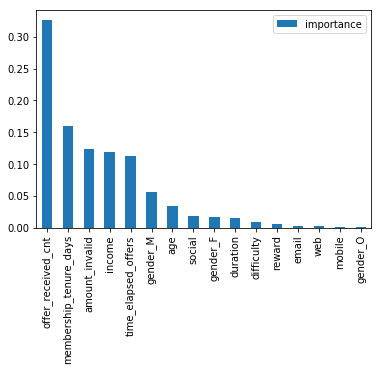

In [144]:
feature_importances.plot.bar()

In [145]:
features,target=data_prep(offers_bogo,drop_cols_prep);
X_train, X_test, y_train, y_test=model_pipeline(features,target,2)

In [146]:
#Initialize the model
# clf1 = DecisionTreeClassifier(criterion='entropy',max_depth=5,random_state=2,min_samples_split=90,min_samples_leaf=50)
clf1= AdaBoostClassifier(base_estimator=DecisionTreeClassifier(criterion='entropy',max_depth=8,random_state=2,min_samples_split=40,min_samples_leaf=50),n_estimators=10,learning_rate=0.2,random_state=2)
clf2 = RandomForestClassifier(max_depth= 5, max_features= 'auto',min_samples_split= 10,n_estimators=20,min_samples_leaf=10)
# clf2 =LogisticRegression(penalty='l2',random_state=2,C=1.5,max_iter=200)

run_model(clf1,clf2)

AdaBoostClassifier trained on 266 samples.
MSE_train: 0.2367
MSE_test: 0.3207
Training score:0.6824
Test score:0.6793
AdaBoostClassifier trained on 26686 samples.
MSE_train: 0.2700
MSE_test: 0.3037
Training score:0.7109
Test score:0.6963
RandomForestClassifier trained on 266 samples.
MSE_train: 0.2233
MSE_test: 0.3085
Training score:0.6936
Test score:0.6915
RandomForestClassifier trained on 26686 samples.
MSE_train: 0.2733
MSE_test: 0.2957
Training score:0.7090
Test score:0.7043


In [147]:
# samples_1=int(0.10*len(y_train))
# def rand_forest_param_selection(X,y):
#     param_grid={'max_features': ['auto', 'sqrt'],
#                 'max_depth' : [5,10,20],
#                 'n_estimators': [10,20, 30, 40],
#                 'min_samples_split': [2, 10, 20],
#                 }
#     grid_search = GridSearchCV(RandomForestClassifier(random_state=2), param_grid)
#     grid_search.fit(X, y)
#     grid_search.best_params_
#     return grid_search.best_params_
# rand_forest_param_selection(X_train[:samples_1], y_train[:samples_1])

Now that we've analysed the drivers of an effective bogo offer, can we predict how much a person would spend for an effective offer vs an ineffective offer?

In [148]:
#drop duplicates for spend and offers
offers_bogo_tmp.drop_duplicates(subset=['person','offer_id'],inplace=True);

NameError: name 'offers_bogo_tmp' is not defined

In [149]:
#data prep
offers_bogo_tmp_effective=offers_bogo[offers_bogo['effective_offer']==1].copy()
offers_bogo_tmp_ineffective=offers_bogo[offers_bogo['effective_offer']==0].copy()

Effective offers

In [150]:
drop_cols_offer=['person','offer_id','effective_offer','offer_type','amount']
target = offers_bogo_tmp_effective['amount']
features = drop_cols(drop_cols_offer,offers_bogo_tmp_effective)

In [151]:
X_train, X_test, y_train, y_test=model_pipeline(features,target)

In [152]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

In [153]:
#Initialize the model
clf1 = LinearRegression()
clf2 = DecisionTreeRegressor(max_depth=4,min_samples_leaf=10,min_samples_split=10,max_leaf_nodes=8,random_state=42)

run_model(clf1,clf2)

LinearRegression trained on 77 samples.
MSE_train: 12972.4096
MSE_test: 5999.1495
Training score:-0.0323
Test score:-0.0328
LinearRegression trained on 7791 samples.
MSE_train: 12123.7890
MSE_test: 5333.2214
Training score:0.0574
Test score:0.0818
DecisionTreeRegressor trained on 77 samples.
MSE_train: 12559.3028
MSE_test: 6032.0985
Training score:-0.0266
Test score:-0.0385
DecisionTreeRegressor trained on 7791 samples.
MSE_train: 11440.0320
MSE_test: 5507.8163
Training score:0.0636
Test score:0.0518


Offers discount model

In [154]:
drop_cols_prep=['offer_type','person','amount','offer_id','effective_offer'] 
features,target=data_prep(offers_discount,drop_cols_prep);
X_train, X_test, y_train, y_test=model_pipeline(features,target)

In [155]:
#Initialize the model
# clf1 = DecisionTreeClassifier(criterion='entropy',max_depth=5,random_state=2,min_samples_split=90,min_samples_leaf=50)
clf1= AdaBoostClassifier(base_estimator=DecisionTreeClassifier(criterion='entropy',max_depth=8,random_state=2,min_samples_split=40,min_samples_leaf=50),n_estimators=10,learning_rate=0.2,random_state=2)
clf2 = RandomForestClassifier(max_depth= 5, max_features= 'auto',min_samples_split= 10,n_estimators=20,min_samples_leaf=10)
# clf2 =LogisticRegression(penalty='l2',random_state=2,C=1.5,max_iter=200)

run_model(clf1,clf2)

AdaBoostClassifier trained on 273 samples.
MSE_train: 0.2733
MSE_test: 0.3137
Training score:0.6854
Test score:0.6863
AdaBoostClassifier trained on 27339 samples.
MSE_train: 0.2800
MSE_test: 0.3358
Training score:0.6903
Test score:0.6642
RandomForestClassifier trained on 273 samples.
MSE_train: 0.2733
MSE_test: 0.3129
Training score:0.6849
Test score:0.6871
RandomForestClassifier trained on 27339 samples.
MSE_train: 0.2733
MSE_test: 0.3137
Training score:0.6854
Test score:0.6863


In [156]:
drop_cols_offer=['person','offer_id','effective_offer','offer_type','amount']
target = offers_bogo_tmp_ineffective['amount']
features = drop_cols(drop_cols_offer,offers_bogo_tmp_ineffective)

X_train, X_test, y_train, y_test=model_pipeline(features,target)

#Initialize the model
clf1 = LinearRegression()
clf2 = DecisionTreeRegressor(max_depth=4,min_samples_leaf=10,min_samples_split=10,max_leaf_nodes=8,random_state=42)

run_model(clf1,clf2)

LinearRegression trained on 188 samples.
MSE_train: 6413.4058
MSE_test: 4196.8155
Training score:0.0173
Test score:0.0359
LinearRegression trained on 18895 samples.
MSE_train: 6400.9548
MSE_test: 3935.1059
Training score:0.0964
Test score:0.0961
DecisionTreeRegressor trained on 188 samples.
MSE_train: 6499.4481
MSE_test: 4608.3724
Training score:-0.0813
Test score:-0.0586
DecisionTreeRegressor trained on 18895 samples.
MSE_train: 6297.4689
MSE_test: 4001.2850
Training score:0.0783
Test score:0.0808


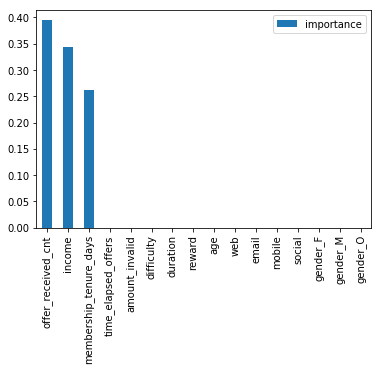

In [157]:
feature_importances = pd.DataFrame(clf2.feature_importances_,
                                   index = features.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)
feature_importances.plot.bar()

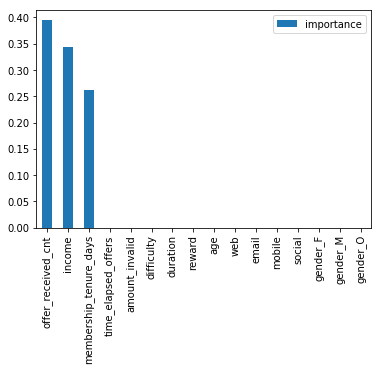

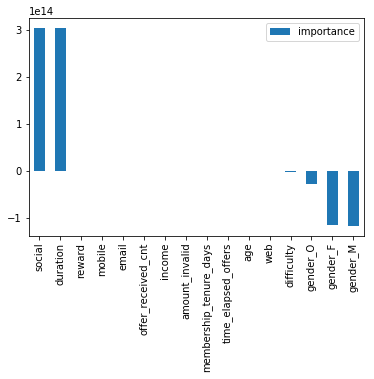

In [158]:
feature_importances = pd.DataFrame(clf2.feature_importances_,
                                   index = features.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)
feature_importances.plot.bar()

feature_importances = pd.DataFrame(clf1.coef_.T,
                                   index = features.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)
feature_importances.plot.bar()

In [159]:
features,target=data_prep(offers_info)
X_train, X_test, y_train, y_test=model_pipeline(features,target)

In [160]:
#Initialize the model
# clf1 = DecisionTreeClassifier(criterion='entropy',max_depth=5,random_state=2,min_samples_split=90,min_samples_leaf=50)
clf1= AdaBoostClassifier(base_estimator=DecisionTreeClassifier(criterion='entropy',max_depth=8,random_state=2,min_samples_split=40,min_samples_leaf=50),n_estimators=10,learning_rate=0.2,random_state=2)
clf2 = RandomForestClassifier(max_depth= 5, max_features= 'auto',min_samples_split= 10,n_estimators=20,min_samples_leaf=10)
# clf2 =LogisticRegression(penalty='l2',random_state=2,C=1.5,max_iter=200)

run_model(clf1,clf2)

AdaBoostClassifier trained on 136 samples.
MSE_train: 0.3433
MSE_test: 0.3128
Training score:0.6829
Test score:0.6872
AdaBoostClassifier trained on 13665 samples.
MSE_train: 0.3400
MSE_test: 0.3248
Training score:0.6855
Test score:0.6752
RandomForestClassifier trained on 136 samples.
MSE_train: 0.3433
MSE_test: 0.3292
Training score:0.6664
Test score:0.6708
RandomForestClassifier trained on 13665 samples.
MSE_train: 0.3433
MSE_test: 0.3128
Training score:0.6829
Test score:0.6872


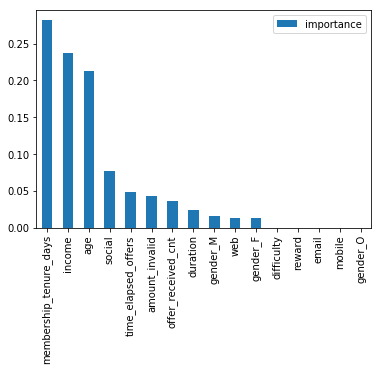

In [161]:
feature_importances = pd.DataFrame(clf1.feature_importances_,
                                   index = features.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)
feature_importances.plot.bar()

In [452]:
from sklearn.preprocessing import FunctionTransformer

In [453]:
def model_pipeline(features,target,poly_feat=0):
    #split into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(features,target, 
                                                        test_size=0.20, 
                                                        random_state=42)
#     #fit and transform training data
#     poly = PolynomialFeatures(poly_feat)
#     X_train_poly=poly.fit_transform(X_train)
    
#     #transform test data
#     X_test_poly=poly.transform(X_test)
    
    transformer = FunctionTransformer(np.log1p, validate=True)
    X_train=transformer.fit_transform(X_train)
    X_test=transformer.transform(X_test)
    
    #fit and transform scaling on training data
    scaler=StandardScaler()
    X_train=scaler.fit_transform(X_train)

    #scale test data
    X_test=scaler.transform(X_test)
    return X_train,X_test,y_train, y_test

In [454]:
drop_cols_prep=['offer_type','person','amount','offer_id','effective_offer','difficulty','reward','email','mobile','gender_O']
features,target=data_prep(offers_info,drop_cols_prep)
X_train, X_test, y_train, y_test=model_pipeline(features,target,6)

In [455]:
#Initialize the model
# clf1 = DecisionTreeClassifier(criterion='entropy',max_depth=5,random_state=2,min_samples_split=90,min_samples_leaf=50)
clf1= AdaBoostClassifier(base_estimator=DecisionTreeClassifier(criterion='entropy',max_depth=8,random_state=2,min_samples_split=40,min_samples_leaf=50),n_estimators=10,learning_rate=0.2,random_state=2)
# clf2 = RandomForestClassifier(max_depth= 5, max_features= 'auto',min_samples_split= 10,n_estimators=20,min_samples_leaf=10)
clf2 =LogisticRegression(penalty='l2',random_state=2,C=0.9,max_iter=500)

run_model(clf1,clf2)

AdaBoostClassifier trained on 136 samples.
MSE_train: 0.3433
MSE_test: 0.3128
Training score:0.6829
Test score:0.6872
AdaBoostClassifier trained on 13665 samples.
MSE_train: 0.3467
MSE_test: 0.3234
Training score:0.6852
Test score:0.6766
LogisticRegression trained on 136 samples.
MSE_train: 0.3433
MSE_test: 0.3342
Training score:0.6550
Test score:0.6658
LogisticRegression trained on 13665 samples.
MSE_train: 0.3433
MSE_test: 0.3134
Training score:0.6825
Test score:0.6866


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


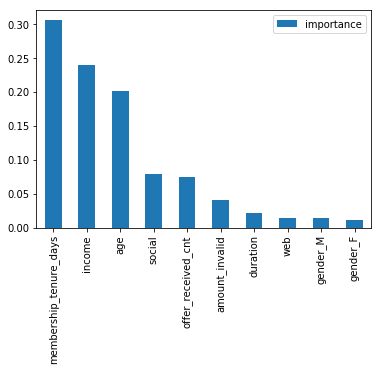

In [456]:
feature_importances = pd.DataFrame(clf1.feature_importances_,
                                   index = features.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)
feature_importances.plot.bar()

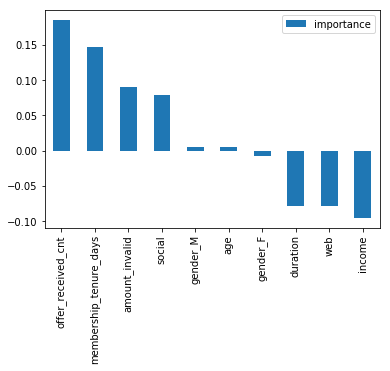

In [457]:
feature_importances = pd.DataFrame(clf2.coef_.T,
                                   index = features.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)
feature_importances.plot.bar()

In [ ]:
# def svc_param_selection(X, y):
#     Cs = [0.001, 0.01, 0.1, 1, 10]
#     gammas = [0.001, 0.01, 0.1, 1]
#     kernel=['poly','rbf','linear','sigmoid']
#     param_grid = {'C': Cs, 'gamma' : gammas,'kernel': kernel}
#     grid_search = GridSearchCV(svm.SVC(random_state=2), param_grid)
#     grid_search.fit(X, y)
#     grid_search.best_params_
#     return grid_search.best_params_

In [ ]:
# def rand_forest_param_selection(X,y):
#     param_grid={'max_features': ['auto', 'sqrt'],
#                 'max_depth' : [5,10],
#                 'n_estimators': [20, 30, 40],
#                 'min_samples_split': [2, 10, 20],
#                 }
#     grid_search = GridSearchCV(RandomForestClassifier(random_state=2), param_grid)
#     grid_search.fit(X, y)
#     grid_search.best_params_
#     return grid_search.best_params_
# rand_forest_param_selection(X_train[:samples_1], y_train[:samples_1])

Attempting multiclass classification

In [458]:
#append datasets together
offers=offers_discount.append(offers_bogo)
offers=offers.append(offers_info)

In [459]:
#prepare multiclasses
offers['type']=np.nan
offers.loc[offers['offer_type']=='bogo','type']=0
offers.loc[offers['offer_type']=='discount','type']=1
offers.loc[offers['offer_type']=='informational','type']=2

In [460]:
#data prep
temp=drop_cols(['offer_type','amount'],offers)
# temp.drop_duplicates(subset=['person','offer_id','type'])
drop_cols_offer=['person','offer_id','effective_offer']
target = temp['effective_offer']
features = drop_cols(drop_cols_offer,temp)

In [461]:
def model_pipeline(features,target):
    #split into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(features,target, 
                                                        test_size=0.20, 
                                                        random_state=42)
    
    #fit and transform scaling on training data
    scaler=StandardScaler()
    X_train=scaler.fit_transform(X_train)

    #scale test data
    X_test=scaler.transform(X_test)
    return X_train,X_test,y_train, y_test

In [462]:
X_train, X_test, y_train, y_test=model_pipeline(features,target)

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  if sys.path[0] == '':


In [463]:
#Initialize the model
clf1 = DecisionTreeClassifier(criterion='entropy',max_depth=6,random_state=2,min_samples_split=90,min_samples_leaf=50)
clf2 = RandomForestClassifier(max_depth= 6, max_features= 'auto',min_samples_split= 10,n_estimators=20,min_samples_leaf=10)

#run model
run_model(clf1,clf2)

DecisionTreeClassifier trained on 676 samples.
MSE_train: 0.2800
MSE_test: 0.3037
Training score:0.6935
Test score:0.6963
DecisionTreeClassifier trained on 67691 samples.
MSE_train: 0.2800
MSE_test: 0.3037
Training score:0.6935
Test score:0.6963
RandomForestClassifier trained on 676 samples.
MSE_train: 0.2800
MSE_test: 0.3037
Training score:0.6935
Test score:0.6963
RandomForestClassifier trained on 67691 samples.
MSE_train: 0.2800
MSE_test: 0.3037
Training score:0.6935
Test score:0.6963


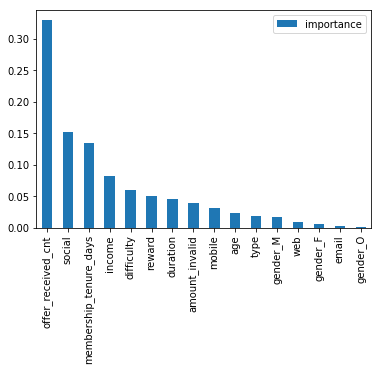

In [464]:
feature_importances = pd.DataFrame(clf2.feature_importances_,
                                   index = features.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)
feature_importances.plot.bar()

In [465]:
#data prep
temp=drop_cols(['offer_type','amount','gender_O','web','email','mobile'],offers)
# temp.drop_duplicates(subset=['person','offer_id','type'])
drop_cols_offer=['person','offer_id','effective_offer']
target = temp['effective_offer']
features = drop_cols(drop_cols_offer,temp)

X_train, X_test, y_train, y_test=model_pipeline(features,target)

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  if sys.path[0] == '':


In [466]:
#Initialize the model
clf1 = DecisionTreeClassifier(criterion='entropy',max_depth=6,random_state=2,min_samples_split=90,min_samples_leaf=50)
clf2 = RandomForestClassifier(max_depth= 6, max_features= 'auto',min_samples_split= 10,n_estimators=20,min_samples_leaf=10)

#run model
run_model(clf1,clf2)

DecisionTreeClassifier trained on 676 samples.
MSE_train: 0.2800
MSE_test: 0.3037
Training score:0.6935
Test score:0.6963
DecisionTreeClassifier trained on 67691 samples.
MSE_train: 0.2800
MSE_test: 0.3037
Training score:0.6935
Test score:0.6963
RandomForestClassifier trained on 676 samples.
MSE_train: 0.2800
MSE_test: 0.3037
Training score:0.6935
Test score:0.6963
RandomForestClassifier trained on 67691 samples.
MSE_train: 0.2800
MSE_test: 0.3037
Training score:0.6935
Test score:0.6963


Attempting feature engineering with polynomial features

In [467]:
def data_prep(df):
    #drop unnecessary columns
    drop_cols_offer=['offer_type','amount']
    temp=drop_cols(drop_cols_offer,df)
    # Split the data into features and target label
    drop_cols_offer=['person','offer_id','effective_offer']
    target = temp['effective_offer']
    features = drop_cols(drop_cols_offer,temp)
    return features,target

In [469]:
features,target=data_prep(offers_bogo)

In [471]:
X_train, X_test, y_train, y_test=model_pipeline(features,target)

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  if sys.path[0] == '':


In [472]:
def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: review_scores_rating training set
       - X_test: features testing set
       - y_test: review_scores_rating testing set
    '''
    results = {}
    
    #Fit the learner to the training data and get training time
    start = time() 
    learner = learner.fit(X_train[:sample_size], y_train[:sample_size])
    end = time() 
    results['train_time'] = end-start
    
    # Get predictions on the test set(X_test), then get predictions on first 300 training samples
    start = time() 
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train[:300])
    end = time() 
    
    # Calculate the total prediction time
    results['pred_time'] = end-start
    
    #Compute accuracy on the first 300 training samples
    results['mse_train'] = mean_squared_error(y_train[:300],predictions_train)
    
    #Compute accuracy on test set
    results['mse_test'] = mean_squared_error(y_test,predictions_test)
    
    print("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))
    print("MSE_train: %.4f" % results['mse_train'])
    print("MSE_test: %.4f" % results['mse_test'])
    print("Training score:%.4f" % learner.score(X_train,y_train))
    print("Test score:%.4f" % learner.score(X_test,y_test))
    return results

In [473]:
def run_model(clf1,clf2,clf3):
    # Calculate the number of samples for 1% and 100% of the training data
    samples_100 = len(y_train)
    samples_1 = int(0.01*len(y_train))

    # Collect results on the learners
    results = {}
    for clf in [clf1, clf2,clf3]:
        clf_name = clf.__class__.__name__
        results[clf_name] = {}
        for i, samples in enumerate([samples_1, samples_100]):
            results[clf_name][i] = \
            train_predict(clf, samples, X_train, y_train, X_test, y_test)

In [474]:
#Initialize the model
clf1 = svm.SVC(C= 0.1, gamma= 0.001, kernel= 'rbf')
clf2 = RandomForestClassifier(max_depth= 5, max_features= 'auto',min_samples_split= 10,n_estimators=20,min_samples_leaf=10)
clf3 = DecisionTreeClassifier(criterion='entropy',max_depth=5,random_state=2,min_samples_split=90,min_samples_leaf=50)

run_model(clf1,clf2,clf3)

SVC trained on 266 samples.
MSE_train: 0.2733
MSE_test: 0.2957
Training score:0.7090
Test score:0.7043


KeyboardInterrupt: 

Overall model - no correlation!

In [195]:
offers_effective=offers[offers['effective_offer']==1].copy()

In [196]:
offers_effective['bogo']=np.where(offers_effective['offer_type']=='bogo',1,0)
offers_effective['discount']=np.where(offers_effective['offer_type']=='discount',1,0)
offers_effective['info']=np.where(offers_effective['offer_type']=='informational',1,0)

In [197]:
drop_cols('offer_type',offers_effective,inplace=True);

In [198]:
offers_effective.drop_duplicates(subset=['person','offer_id','amount'],inplace=True)

In [199]:
#data prep
drop_cols_offer=['person','offer_id','amount','effective_offer']
target = offers_effective['amount']
features = drop_cols(drop_cols_offer,offers_effective)

In [200]:
def model_pipeline(features,target,poly_feat=0):
    #split into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(features,target, 
                                                        test_size=0.20, 
                                                        random_state=42)
    #fit and transform training data
    poly = PolynomialFeatures(poly_feat)
    X_train_poly=poly.fit_transform(X_train)
    
    #transform test data
    X_test_poly=poly.transform(X_test)
    
    #fit and transform scaling on training data
    scaler=StandardScaler()
    X_train=scaler.fit_transform(X_train)

    #scale test data
    X_test=scaler.transform(X_test)
    return X_train,X_test,y_train, y_test

In [201]:
X_train, X_test, y_train, y_test=model_pipeline(features,target)

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.


In [202]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression

In [203]:
def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: review_scores_rating training set
       - X_test: features testing set
       - y_test: review_scores_rating testing set
    '''
    results = {}
    
    #Fit the learner to the training data and get training time
    start = time() 
    learner = learner.fit(X_train[:sample_size], y_train[:sample_size])
    end = time() 
    results['train_time'] = end-start
    
    # Get predictions on the test set(X_test), then get predictions on first 300 training samples
    start = time() 
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train[:300])
    end = time() 
    
    # Calculate the total prediction time
    results['pred_time'] = end-start
    
#     #Compute accuracy on the first 300 training samples
#     results['mse_train'] = mean_squared_error(y_train[:300],predictions_train)
    
#     #Compute accuracy on test set
#     results['mse_test'] = mean_squared_error(y_test,predictions_test)
    
    print("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))
#     print("MSE_train: %.4f" % results['mse_train'])
#     print("MSE_test: %.4f" % results['mse_test'])
    print("Training score:%.4f" % learner.score(X_train,y_train))
    print("Test score:%.4f" % learner.score(X_test,y_test))
    return results

In [204]:
def run_model(clf1,clf2):
    # Calculate the number of samples for 1% and 100% of the training data
    samples_100 = len(y_train)
    samples_1 = int(0.01*len(y_train))

    # Collect results on the learners
    results = {}
    for clf in [clf1, clf2]:
        clf_name = clf.__class__.__name__
        results[clf_name] = {}
        for i, samples in enumerate([samples_1, samples_100]):
            results[clf_name][i] = \
            train_predict(clf, samples, X_train, y_train, X_test, y_test)

In [205]:
#Initialize the model
clf1 = DecisionTreeRegressor()
clf2 = LinearRegression()

run_model(clf1,clf2)

DecisionTreeRegressor trained on 709 samples.
Training score:-0.1471
Test score:-0.1675
DecisionTreeRegressor trained on 70952 samples.
Training score:0.4442
Test score:-0.6852
LinearRegression trained on 709 samples.
Training score:0.0375
Test score:0.0384
LinearRegression trained on 70952 samples.
Training score:0.0471
Test score:0.0469


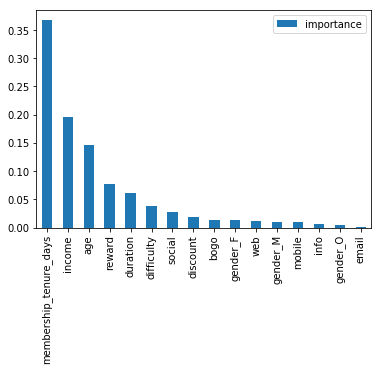

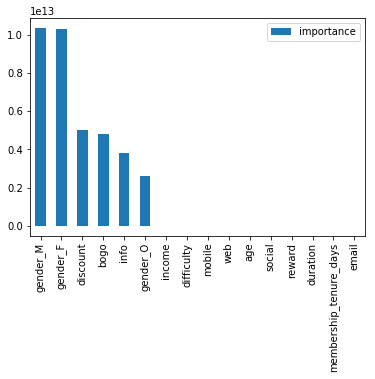

In [206]:
feature_importances = pd.DataFrame(clf1.feature_importances_,
                                   index = features.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)
feature_importances.plot.bar()

feature_importances = pd.DataFrame(clf2.coef_.T,
                                   index = features.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)
feature_importances.plot.bar()

In [209]:
#data prep
drop_cols_offer=['person','offer_id','amount','gender_O','income','age','membership_tenure_days','reward','duration','mobile','web','social','email','difficulty']
target = offers_effective['amount']
features = drop_cols(drop_cols_offer,offers_effective)

X_train, X_test, y_train, y_test=model_pipeline(features,target)

#Initialize the model
clf1 = LinearRegression()
clf2 = DecisionTreeRegressor(max_depth=4,min_samples_leaf=10,min_samples_split=10,max_leaf_nodes=8,random_state=42)

run_model(clf1,clf2)

LinearRegression trained on 709 samples.
Training score:0.0033
Test score:0.0019
LinearRegression trained on 70952 samples.
Training score:0.0064
Test score:0.0055
DecisionTreeRegressor trained on 709 samples.
Training score:0.0026
Test score:0.0009
DecisionTreeRegressor trained on 70952 samples.
Training score:0.0066
Test score:0.0060


/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
